# Introduction to Keras for Researchers

**Author:** [fchollet](https://twitter.com/fchollet)<br>
**Date created:** 2020/04/01<br>
**Last modified:** 2020/10/02<br>
**Description:** Everything you need to know to use Keras & TensorFlow for deep learning research.

## Setup

In [113]:
import tensorflow as tf
from tensorflow import keras

## Introduction

Are you a machine learning researcher? Do you publish at NeurIPS and push the
state-of-the-art in CV and NLP? This guide will serve as your first introduction to core
Keras & TensorFlow API concepts.

In this guide, you will learn about:

- Tensors, variables, and gradients in TensorFlow
- Creating layers by subclassing the `Layer` class
- Writing low-level training loops
- Tracking losses created by layers via the `add_loss()` method
- Tracking metrics in a low-level training loop
- Speeding up execution with a compiled `tf.function`
- Executing layers in training or inference mode
- The Keras Functional API

You will also see the Keras API in action in two end-to-end research examples:
a Variational Autoencoder, and a Hypernetwork.

## Tensors

TensorFlow is an infrastructure layer for differentiable programming.
At its heart, it's a framework for manipulating N-dimensional arrays (tensors),
much like NumPy.

However, there are three key differences between NumPy and TensorFlow:

- TensorFlow can leverage hardware accelerators such as GPUs and TPUs.
- TensorFlow can automatically compute the gradient of arbitrary differentiable tensor expressions.
- TensorFlow computation can be distributed to large numbers of devices on a single machine, and large number of
machines (potentially with multiple devices each).

Let's take a look at the object that is at the core of TensorFlow: the Tensor.

Here's a constant tensor:

In [114]:
x = tf.constant([[5, 2], [1, 3]])
print(x)

tf.Tensor(
[[5 2]
 [1 3]], shape=(2, 2), dtype=int32)


You can get its value as a NumPy array by calling `.numpy()`:

In [115]:
x.numpy()

array([[5, 2],
       [1, 3]], dtype=int32)

Much like a NumPy array, it features the attributes `dtype` and `shape`:

In [116]:
print("dtype:", x.dtype)
print("shape:", x.shape)

dtype: <dtype: 'int32'>
shape: (2, 2)


A common way to create constant tensors is via `tf.ones` and `tf.zeros` (just like `np.ones` and `np.zeros`):

In [117]:
print(tf.ones(shape=(2, 1)))
print(tf.zeros(shape=(2, 1)))

tf.Tensor(
[[1.]
 [1.]], shape=(2, 1), dtype=float32)
tf.Tensor(
[[0.]
 [0.]], shape=(2, 1), dtype=float32)


You can also create random constant tensors:

In [118]:
x = tf.random.normal(shape=(2, 2), mean=0.0, stddev=1.0)

x = tf.random.uniform(shape=(2, 2), minval=0, maxval=10, dtype="int32")

In [119]:
x

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[5, 5],
       [4, 3]], dtype=int32)>

## Variables

Variables are special tensors used to store mutable state (such as the weights of a neural network).
You create a `Variable` using some initial value:

In [120]:
initial_value = tf.random.normal(shape=(2, 2))
a = tf.Variable(initial_value)
print(a)


<tf.Variable 'Variable:0' shape=(2, 2) dtype=float32, numpy=
array([[ 0.12035114, -1.7982358 ],
       [-1.3611834 , -1.7197502 ]], dtype=float32)>


You update the value of a `Variable` by using the methods `.assign(value)`, `.assign_add(increment)`, or `.assign_sub(decrement)`:

In [121]:
new_value = tf.random.normal(shape=(2, 2))
a.assign(new_value)
for i in range(2):
    for j in range(2):
        assert a[i, j] == new_value[i, j]
# ==> not error as a is identical to new_value

added_value = tf.random.normal(shape=(2, 2))
a.assign_add(added_value)
for i in range(2):
    for j in range(2):
        assert a[i, j] == new_value[i, j] + added_value[i, j]

# ==> not error as a = a+new_value

## Doing math in TensorFlow

If you've used NumPy, doing math in TensorFlow will look very familiar.
The main difference is that your TensorFlow code can run on GPU and TPU.

In [122]:
a = tf.random.normal(shape=(2, 2))
b = tf.random.normal(shape=(2, 2))
print((a, b))
c = a + b
print(c)
d = tf.square(c)
print(d)
e = tf.exp(d)
print(e)

(<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[1.1259619 , 0.74148864],
       [0.44353807, 2.546761  ]], dtype=float32)>, <tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[ 0.07535713,  0.71886635],
       [-0.5288239 ,  0.3679201 ]], dtype=float32)>)
tf.Tensor(
[[ 1.201319    1.460355  ]
 [-0.08528584  2.9146812 ]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[1.4431673e+00 2.1326368e+00]
 [7.2736749e-03 8.4953661e+00]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[4.2340856e+00 8.4370842e+00]
 [1.0073003e+00 4.8920469e+03]], shape=(2, 2), dtype=float32)


## Gradients

Here's another big difference with NumPy: you can automatically retrieve the gradient of any differentiable expression.

Just open a `GradientTape`, start "watching" a tensor via `tape.watch()`,
and compose a differentiable expression using this tensor as input:

In [123]:
a = tf.random.normal(shape=(2, 2))
b = tf.random.normal(shape=(2, 2))
print(a)
print(b)
with tf.GradientTape() as tape:
    tape.watch(a)  # Start recording the history of operations applied to `a`
    c = tf.sqrt(tf.square(a) + tf.square(b))  # Do some math using `a`
    print(c)
    # What's the gradient of `c` with respect to `a`?
    dc_da = tape.gradient(c, a)
    print(dc_da)


tf.Tensor(
[[-1.7366021  -1.9455265 ]
 [ 2.3273423   0.13184905]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.60686404  0.431008  ]
 [ 0.84436864  2.4843526 ]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[1.8395844 1.992697 ]
 [2.4757788 2.4878488]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.94401866 -0.97632825]
 [ 0.94004446  0.05299721]], shape=(2, 2), dtype=float32)


By default, variables are watched automatically, so you don't need to manually `watch` them:

In [124]:
a = tf.Variable(a)

with tf.GradientTape() as tape:
    c = tf.sqrt(tf.square(a) + tf.square(b))
    dc_da = tape.gradient(c, a)
    print(dc_da)

tf.Tensor(
[[-0.94401866 -0.97632825]
 [ 0.94004446  0.05299721]], shape=(2, 2), dtype=float32)


Note that you can compute higher-order derivatives by nesting tapes:

In [126]:
with tf.GradientTape() as outer_tape:
    with tf.GradientTape() as tape:
        c = tf.sqrt(tf.square(a) + tf.square(b))
        dc_da = tape.gradient(c, a)
    d2c_da2 = outer_tape.gradient(dc_da, a)
    print(d2c_da2)


tf.Tensor(
[[0.05915943 0.02347723]
 [0.04698169 0.40082473]], shape=(2, 2), dtype=float32)


## Keras layers

While TensorFlow is an **infrastructure layer for differentiable programming**,
dealing with tensors, variables, and gradients,
Keras is a **user interface for deep learning**, dealing with
layers, models, optimizers, loss functions, metrics, and more.

Keras serves as the high-level API for TensorFlow:
Keras is what makes TensorFlow simple and productive.

The `Layer` class is the fundamental abstraction in Keras.
A `Layer` encapsulates a state (weights) and some computation
(defined in the call method).

A simple layer looks like this:

In [159]:

class Linear(keras.layers.Layer):
    """y = w.x + b"""

    def __init__(self, units=32, input_dim=32):
        super(Linear, self).__init__()
        w_init = tf.random_normal_initializer()
        self.w = tf.Variable(
            initial_value=w_init(shape=(input_dim, units), dtype="float32"),
            trainable=True,
        )
        b_init = tf.zeros_initializer()
        self.b = tf.Variable(
            initial_value=b_init(shape=(units,), dtype="float32"), trainable=True
        )

    def call(self, inputs, verbose=False):
        y = tf.matmul(inputs, self.w) + self.b
        if verbose:
            print(f"w:{self.w.numpy()}\n x:{inputs.numpy()}\nb:{self.b.numpy()}\n"
                  f"y=w.x + b :{y.numpy()}")
            print(f"input shape :{inputs.shape}\n w.shape:{self.w.shape}==>y.shape:{y.shape}\n")
        return y


You would use a `Layer` instance much like a Python function:

In [137]:
# Instantiate our layer.
linear_layer = Linear(units=4, input_dim=2)

# The layer can be treated as a function.
# Here we call it on some data.
y = linear_layer(tf.ones((2, 2)), verbose=True)
assert y.shape == (2, 4)

w:[[ 0.0076049  -0.07012887 -0.04773425 -0.00262079]
 [ 0.05354334  0.04409512  0.0227464   0.02578265]]
 x:[[1. 1.]
 [1. 1.]]
b:[0. 0. 0. 0.]
y=w.x + b :[[ 0.06114824 -0.02603376 -0.02498785  0.02316186]
 [ 0.06114824 -0.02603376 -0.02498785  0.02316186]]


In [136]:
y

<tf.Tensor: shape=(2, 4), dtype=float32, numpy=
array([[ 0.12270289, -0.0298899 , -0.02255606, -0.01399952],
       [ 0.12270289, -0.0298899 , -0.02255606, -0.01399952]],
      dtype=float32)>

The weight variables (created in `__init__`) are automatically
tracked under the `weights` property:

In [24]:
assert linear_layer.weights == [linear_layer.w, linear_layer.b]

In [23]:
print(linear_layer.weights)

[<tf.Variable 'Variable:0' shape=(2, 4) dtype=float32, numpy=
array([[ 0.03813144, -0.02071256, -0.03505637,  0.00399174],
       [ 0.01746974,  0.04218847,  0.02382193,  0.01064391]],
      dtype=float32)>, <tf.Variable 'Variable:0' shape=(4,) dtype=float32, numpy=array([0., 0., 0., 0.], dtype=float32)>]


You have many built-in layers available, from `Dense` to `Conv2D` to `LSTM` to
fancier ones like `Conv3DTranspose` or `ConvLSTM2D`. Be smart about reusing
built-in functionality.

## Layer weight creation

The `self.add_weight()` method gives you a shortcut for creating weights:

In [213]:

class Linear(keras.layers.Layer):
    """y = w.x + b"""

    def __init__(self, units=32):
        super(Linear, self).__init__()
        self.units = units

    def build(self, input_shape):
        self.w = self.add_weight(
            shape=(input_shape[-1], self.units),
            initializer="random_normal",
            trainable=True,
        )
        self.b = self.add_weight(
            shape=(self.units,), initializer="random_normal", trainable=True
        )

    def call(self, inputs, verbose=0):
        y = tf.matmul(inputs, self.w) + self.b
        if verbose > 1:
            print(f"w:{self.w.numpy()}\n x:{inputs.numpy()}\nb:{self.b.numpy()}\n"
                  f"y=w.x + b :{y.numpy()}")
        if verbose > 0:
            print(f"input shape :{inputs.shape}\n w.shape:{self.w.shape}==>y.shape:{y.shape}\n")

        return y


In [143]:
# Instantiate our lazy layer.
linear_layer = Linear(4)

# This will also call `build(input_shape)` and create the weights.
y = linear_layer(tf.ones((2, 2)))

print(linear_layer.weights)
print(linear_layer.b)

print(linear_layer.trainable_weights)

[<tf.Variable 'linear_92/Variable:0' shape=(2, 4) dtype=float32, numpy=
array([[-0.00862231,  0.07198895, -0.04868265, -0.03754042],
       [-0.02301238, -0.06684013, -0.02006219, -0.00278321]],
      dtype=float32)>, <tf.Variable 'linear_92/Variable:0' shape=(4,) dtype=float32, numpy=array([-0.08963311, -0.07027795,  0.10285955,  0.02803845], dtype=float32)>]
<tf.Variable 'linear_92/Variable:0' shape=(4,) dtype=float32, numpy=array([-0.08963311, -0.07027795,  0.10285955,  0.02803845], dtype=float32)>
[<tf.Variable 'linear_92/Variable:0' shape=(2, 4) dtype=float32, numpy=
array([[-0.00862231,  0.07198895, -0.04868265, -0.03754042],
       [-0.02301238, -0.06684013, -0.02006219, -0.00278321]],
      dtype=float32)>, <tf.Variable 'linear_92/Variable:0' shape=(4,) dtype=float32, numpy=array([-0.08963311, -0.07027795,  0.10285955,  0.02803845], dtype=float32)>]


## Layer gradients

You can automatically retrieve the gradients of the weights of a layer by
calling it inside a `GradientTape`. Using these gradients, you can update the
weights of the layer, either manually, or using an optimizer object. Of course,
you can modify the gradients before using them, if you need to.

In [144]:
# Prepare a dataset.
(x_train, y_train), _ = tf.keras.datasets.mnist.load_data()
## create dataset by flattening and normalizing the 60000 MNIST 28*28 pictures
# into a 60000 x 784 matrix
dataset = tf.data.Dataset.from_tensor_slices(
    (x_train.reshape(60000, 784).astype("float32") / 255, y_train)
)
# the dataset is suffled and split into batches of size 64 (==> 937 batches + 1/2 batch)
dataset = dataset.shuffle(buffer_size=1024).batch(64)

# Instantiate our linear layer (defined above) with 10 units.
linear_layer = Linear(10)

# Instantiate a logistic loss function that expects integer targets.
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# Instantiate an optimizer.
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-3)

# Iterate over the batches of the dataset.
for step, (x, y) in enumerate(dataset):

    #before_gradients_weights= linear_layer.trainable_weights.copy()
    # Open a GradientTape.
    with tf.GradientTape() as tape:

        # Forward pass.
        logits = linear_layer(x)

        # Loss value for this batch.
        loss = loss_fn(y, logits)

    # Get gradients of weights wrt the loss.
    gradients = tape.gradient(loss, linear_layer.trainable_weights)

    # Update the weights of our linear layer.
    optimizer.apply_gradients(zip(gradients, linear_layer.trainable_weights))
    #after_gradients_weights= linear_layer.trainable_weights.copy()
    # Logging.
    if step % 100 == 0:
        #print(f"before gradients:\n {before_gradients_weights}\nafter:\n{after_gradients_weights}")
        print("Step:", step, "Loss:", float(loss))

Step: 0 Loss: 2.2955307960510254
Step: 100 Loss: 2.1873698234558105
Step: 200 Loss: 2.1267848014831543
Step: 300 Loss: 2.02071213722229
Step: 400 Loss: 1.9876978397369385
Step: 500 Loss: 1.972541332244873
Step: 600 Loss: 1.7790992259979248
Step: 700 Loss: 1.758790135383606
Step: 800 Loss: 1.584207534790039
Step: 900 Loss: 1.6109975576400757


In [49]:
print(x_train.shape)
for step, (x, y) in enumerate(dataset):
    if step > 0:
        break
    print(f"step {step}: {x.shape}")
print (y_train.shape)
print(y_train[0:5])
print(len(dataset))
print(938*64)

(60000, 28, 28)
step 0: (64, 784)
(60000,)
[5 0 4 1 9]
938
60032


60032

In [40]:
28*28

784

## Trainable and non-trainable weights

Weights created by layers can be either trainable or non-trainable. They're
exposed in `trainable_weights` and `non_trainable_weights` respectively.
Here's a layer with a non-trainable weight:

In [0]:

class ComputeSum(keras.layers.Layer):
    """Returns the sum of the inputs."""

    def __init__(self, input_dim):
        super(ComputeSum, self).__init__()
        # Create a non-trainable weight.
        self.total = tf.Variable(initial_value=tf.zeros((input_dim,)), trainable=False)

    def call(self, inputs):
        self.total.assign_add(tf.reduce_sum(inputs, axis=0))
        return self.total


my_sum = ComputeSum(2)
x = tf.ones((2, 2))

y = my_sum(x)
print(y.numpy())  # [2. 2.]

y = my_sum(x)
print(y.numpy())  # [4. 4.]

assert my_sum.weights == [my_sum.total]
assert my_sum.non_trainable_weights == [my_sum.total]
assert my_sum.trainable_weights == []

## Layers that own layers

Layers can be recursively nested to create bigger computation blocks.
Each layer will track the weights of its sublayers
(both trainable and non-trainable).


In [224]:
# Let's reuse the Linear class
# with a `build` method that we defined above.

class MLP(keras.layers.Layer):
    """Simple stack of Linear layers."""

    def __init__(self):
        super(MLP, self).__init__()
        self.linear_1 = Linear(32)
        self.linear_2 = Linear(32)
        self.linear_3 = Linear(10)

    def call(self, inputs, verbose=0):
        x = self.linear_1(inputs, verbose=verbose)
        x = tf.nn.relu(x)
        x = self.linear_2(x, verbose=verbose)
        x = tf.nn.relu(x)
        return self.linear_3(x, verbose=verbose)


mlp = MLP()

# The first call to the `mlp` object will create the weights.
y = mlp(tf.ones(shape=(9,5)), verbose=1)

# Weights are recursively tracked.
assert len(mlp.weights) == 6

input shape :(9, 5)
 w.shape:(5, 32)==>y.shape:(9, 32)

input shape :(9, 32)
 w.shape:(32, 32)==>y.shape:(9, 32)

input shape :(9, 32)
 w.shape:(32, 10)==>y.shape:(9, 10)



In [165]:
mlp.weights

[<tf.Variable 'mlp_10/linear_121/Variable:0' shape=(5, 32) dtype=float32, numpy=
 array([[ 0.0212304 ,  0.03069573, -0.04896614, -0.10798182,  0.01802329,
          0.00333776,  0.06996189, -0.02113896,  0.02716847,  0.0007975 ,
          0.01537424, -0.03980745,  0.00777488, -0.03025036, -0.05920495,
          0.07301626, -0.05019394, -0.02367886, -0.07033186, -0.00315804,
          0.00564596,  0.02590549,  0.03209966,  0.012593  ,  0.0230407 ,
         -0.06736172, -0.05397589,  0.09367742,  0.05525474,  0.00197809,
         -0.00141543,  0.06735725],
        [-0.01832369, -0.07555577, -0.0457548 ,  0.04737128,  0.05447233,
         -0.03522697,  0.05720258, -0.01429931,  0.01596546,  0.11875289,
          0.01302308,  0.00989528,  0.01168259,  0.00871136, -0.03745395,
         -0.00992392,  0.00791631, -0.04613429,  0.05756058,  0.01620428,
          0.12787561, -0.02084724, -0.02767224,  0.10050056, -0.00692086,
         -0.05099019,  0.08550995,  0.07760909,  0.03996995,  0.03156

Note that our manually-created MLP above is equivalent to the following
built-in option:

In [64]:
mlp = keras.Sequential(
    [
        keras.layers.Dense(32, activation=tf.nn.relu),
        keras.layers.Dense(32, activation=tf.nn.relu),
        keras.layers.Dense(10),
    ]
)

## Tracking losses created by layers

Layers can create losses during the forward pass via the `add_loss()` method.
This is especially useful for regularization losses.
The losses created by sublayers are recursively tracked by the parent layers.

Here's a layer that creates an activity regularization loss:

In [105]:

class ActivityRegularization(keras.layers.Layer):
    """Layer that creates an activity sparsity regularization loss."""

    def __init__(self, rate=1e-2):
        super(ActivityRegularization, self).__init__()
        self.rate = rate

    def call(self, inputs):
        # We use `add_loss` to create a regularization loss
        # that depends on the inputs.
        print(f" in ActivityRegularization input_shape {inputs.shape} tf.reduce_sum(inputs) : {tf.reduce_sum(inputs)}")
        self.add_loss(self.rate * tf.reduce_sum(inputs))
        return inputs

In [82]:
print(tf.ones([3,4]).numpy())
print(tf.reduce_sum(tf.ones([3,4]),axis=0).numpy())
print(tf.reduce_sum(tf.ones([3,4])).numpy())

[[1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]]
[3. 3. 3. 3.]
12.0


Any model incorporating this layer will track this regularization loss:

In [100]:
# Let's use the loss layer in a MLP block.


class SparseMLP(keras.layers.Layer):
    """Stack of Linear layers with a sparsity regularization loss."""

    def __init__(self):
        super(SparseMLP, self).__init__()
        self.linear_1 = Linear(32)
        self.regularization = ActivityRegularization(1e-2)
        self.linear_2 = Linear(32)
        self.regularization2 = ActivityRegularization(1e-3)
        self.linear_3 = Linear(10)

    def call(self, inputs):
        x = self.linear_1(inputs)
        x = tf.nn.relu(x)
        x = self.regularization(x)
        x = self.linear_2(x)
        x = self.regularization2(x)
        return self.linear_3(x)


mlp = SparseMLP()
y = mlp(tf.ones((10, 10)))

print(mlp.losses)  # List containing one float32 scalar

 in ActivityRegularization tf.reduce_sum(inputs) : 17.67035675048828
 in ActivityRegularization tf.reduce_sum(inputs) : -0.42626917362213135
[<tf.Tensor: shape=(), dtype=float32, numpy=0.17670356>, <tf.Tensor: shape=(), dtype=float32, numpy=-0.0004262692>]


These losses are cleared by the top-level layer at the start of each forward
pass -- they don't accumulate. `layer.losses` always contains only the losses
created during the last forward pass. You would typically use these losses by
summing them before computing your gradients when writing a training loop.

In [103]:
# Losses correspond to the *last* forward pass.
mlp = SparseMLP()
mlp(tf.ones((10, 10)))
assert len(mlp.losses) == 2
mlp(tf.ones((10, 10)))
assert len(mlp.losses) == 2  # No accumulation.

 in ActivityRegularization tf.reduce_sum(inputs) : 18.5946102142334
 in ActivityRegularization tf.reduce_sum(inputs) : -6.511703014373779
 in ActivityRegularization tf.reduce_sum(inputs) : 18.5946102142334
 in ActivityRegularization tf.reduce_sum(inputs) : -6.511703014373779


In [106]:
# Let's demonstrate how to use these losses in a training loop.

# Prepare a dataset.
(x_train, y_train), _ = tf.keras.datasets.mnist.load_data()
max_img = 8 #60000
dataset = tf.data.Dataset.from_tensor_slices(
    (x_train[0:max_img].reshape(max_img, 784).astype("float32") / 255, y_train[0:max_img])
)
dataset = dataset.shuffle(buffer_size=1024).batch(4)

# A new MLP.
mlp = SparseMLP()

# Loss and optimizer.
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-3)

for step, (x, y) in enumerate(dataset):
    with tf.GradientTape() as tape:

        # Forward pass.
        logits = mlp(x)

        # External loss value for this batch.
        loss = loss_fn(y, logits)
        print(f"loss before add {loss}")
        print(f"sum(mlp.losses) {sum(mlp.losses)}")
        # Add the losses created during the forward pass.
        loss += sum(mlp.losses)
        print(f"loss after add {loss}")
        # Get gradients of weights wrt the loss.
        gradients = tape.gradient(loss, mlp.trainable_weights)

    # Update the weights of our linear layer.
    optimizer.apply_gradients(zip(gradients, mlp.trainable_weights))

    # Logging.
    if step % 1 == 0:
        print("Step:", step, "Loss:", float(loss))


 in ActivityRegularization input_shape (4, 32) tf.reduce_sum(inputs) : 14.70975399017334
 in ActivityRegularization input_shape (4, 32) tf.reduce_sum(inputs) : -0.3299274146556854
loss before add 2.2465178966522217
sum(mlp.losses) 0.14676761627197266
loss after add 2.3932855129241943
Step: 0 Loss: 2.3932855129241943
 in ActivityRegularization input_shape (4, 32) tf.reduce_sum(inputs) : 17.24642562866211
 in ActivityRegularization input_shape (4, 32) tf.reduce_sum(inputs) : 0.2049802541732788
loss before add 2.3343701362609863
sum(mlp.losses) 0.17266923189163208
loss after add 2.5070393085479736
Step: 1 Loss: 2.5070393085479736


## Keeping track of training metrics

Keras offers a broad range of built-in metrics, like `tf.keras.metrics.AUC`
or `tf.keras.metrics.PrecisionAtRecall`. It's also easy to create your
own metrics in a few lines of code.

To use a metric in a custom training loop, you would:

- Instantiate the metric object, e.g. `metric = tf.keras.metrics.AUC()`
- Call its `metric.udpate_state(targets, predictions)` method for each batch of data
- Query its result via `metric.result()`
- Reset the metric's state at the end of an epoch or at the start of an evaluation via
`metric.reset_states()`

Here's a simple example:

In [112]:
# Prepare a dataset.
(x_train, y_train), _ = tf.keras.datasets.mnist.load_data()
max_img = 60000 #8
dataset = tf.data.Dataset.from_tensor_slices(
    (x_train[0:max_img].reshape(max_img, 784).astype("float32") / 255, y_train[0:max_img])
)
dataset = dataset.shuffle(buffer_size=1024).batch(64)


# Instantiate a metric object
accuracy = tf.keras.metrics.SparseCategoricalAccuracy()

# Prepare our layer, loss, and optimizer.
model = keras.Sequential(
    [
        keras.layers.Dense(32, activation="relu"),
        keras.layers.Dense(32, activation="relu"),
        keras.layers.Dense(10),
    ]
)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

for epoch in range(2):
    # Iterate over the batches of a dataset.
    for step, (x, y) in enumerate(dataset):
        with tf.GradientTape() as tape:
            logits = model(x)
            # Compute the loss value for this batch.
            loss_value = loss_fn(y, logits)

        # Update the state of the `accuracy` metric.
        accuracy.update_state(y, logits)

        # Update the weights of the model to minimize the loss value.
        gradients = tape.gradient(loss_value, model.trainable_weights)
        optimizer.apply_gradients(zip(gradients, model.trainable_weights))

        # Logging the current accuracy value so far.
        if step % 200 == 0:
            print("Epoch:", epoch, "Step:", step)
            print("Total running accuracy so far: %.3f" % accuracy.result())

    # Reset the metric's state at the end of an epoch
    accuracy.reset_states()

Epoch: 0 Step: 0
Total running accuracy so far: 0.094
Epoch: 0 Step: 200
Total running accuracy so far: 0.762
Epoch: 0 Step: 400
Total running accuracy so far: 0.833
Epoch: 0 Step: 600
Total running accuracy so far: 0.860
Epoch: 0 Step: 800
Total running accuracy so far: 0.876
Epoch: 1 Step: 0
Total running accuracy so far: 0.875
Epoch: 1 Step: 200
Total running accuracy so far: 0.938
Epoch: 1 Step: 400
Total running accuracy so far: 0.940
Epoch: 1 Step: 600
Total running accuracy so far: 0.941
Epoch: 1 Step: 800
Total running accuracy so far: 0.941


In addition to this, similarly to the `self.add_loss()` method, you have access
to an `self.add_metric()` method on layers. It tracks the average of
whatever quantity you pass to it. You can reset the value of these metrics
by calling `layer.reset_metrics()` on any layer or model.

## Compiled functions

Running eagerly is great for debugging, but you will get better performance by
compiling your computation into static graphs. Static graphs are a researcher's
best friends. You can compile any function by wrapping it in a `tf.function`
decorator.

In [195]:
# Prepare our layer, loss, and optimizer.
model = keras.Sequential(
    [
        keras.layers.Dense(32, activation="relu"),
        keras.layers.Dense(32, activation="relu"),
        keras.layers.Dense(10),
    ]
)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

# Create a training step function, compiled with tf.function
@tf.function  # Make it fast.
def train_on_batch_compiled(x, y):
    with tf.GradientTape() as tape:
        logits = model(x)
        loss = loss_fn(y, logits)
        gradients = tape.gradient(loss, model.trainable_weights)
    optimizer.apply_gradients(zip(gradients, model.trainable_weights))
    return loss

# Create a training step function, eagerly = not compiled
def train_on_batch_eagerly(x, y):
    with tf.GradientTape() as tape:
        logits = model(x)
        loss = loss_fn(y, logits)
        gradients = tape.gradient(loss, model.trainable_weights)
    optimizer.apply_gradients(zip(gradients, model.trainable_weights))
    return loss

# Prepare a dataset.
(x_train, y_train), _ = tf.keras.datasets.mnist.load_data()
dataset = tf.data.Dataset.from_tensor_slices(
    (x_train.reshape(60000, 784).astype("float32") / 255, y_train)
)
dataset = dataset.shuffle(buffer_size=1024).batch(64)

from datetime import datetime

durations=[datetime.now()]
for step, (x, y) in enumerate(dataset):
    loss = train_on_batch_eagerly(x, y)
    if step % 100 == 0:
        dur = datetime.now()-t1
        #durations.append(dur.second+dur.microsecond/1000)
        durations.append(dur.total_seconds())
        print(f"Step: {step} Loss: {float(loss)}, duration = {durations[-1]}")
        t1 = datetime.now()
        #logging.debug("Step:", step, "Loss:", float(loss))
print(f"average step duration in eagerly mode (not compiled) : {sum([float(d) for d in durations[1:]])/float(len(durations[1:]))}")

durations=[datetime.now()]
t1 = datetime.now()
for step, (x, y) in enumerate(dataset):
    loss = train_on_batch_compiled(x, y)
    if step % 100 == 0:
        dur = datetime.now()-t1
        durations.append(dur.total_seconds())
        print(f"Step: {step} Loss: {float(loss)}, duration = {durations[-1]}")
        t1 = datetime.now()
print(f"average step duration with @tf.function (compiled) : {sum([float(d) for d in durations[1:]])/float(len(durations[1:]))}")

Step: 0 Loss: 2.3697543144226074, duration = 101.908287
Step: 100 Loss: 0.6546822786331177, duration = 0.52169
Step: 200 Loss: 0.26991719007492065, duration = 0.512907
Step: 300 Loss: 0.2292388379573822, duration = 0.488469
Step: 400 Loss: 0.42366543412208557, duration = 0.488305
Step: 500 Loss: 0.41671133041381836, duration = 0.486996
Step: 600 Loss: 0.28479981422424316, duration = 0.486256
Step: 700 Loss: 0.26286056637763977, duration = 0.492842
Step: 800 Loss: 0.1675805151462555, duration = 0.484741
Step: 900 Loss: 0.18672534823417664, duration = 0.488696
average step duration in eagerly mode (not compiled) : 10.6359189
Step: 0 Loss: 0.3775084614753723, duration = 0.480845
Step: 100 Loss: 0.06761875748634338, duration = 0.089827
Step: 200 Loss: 0.2935882806777954, duration = 0.088058
Step: 300 Loss: 0.32970544695854187, duration = 0.088832
Step: 400 Loss: 0.16807395219802856, duration = 0.087339
Step: 500 Loss: 0.39689990878105164, duration = 0.088798
Step: 600 Loss: 0.2481648474931

In [194]:
sum([float(d) for d in durations[1:]])/float(len(durations[1:]))
#

0.1627343

## Training mode & inference mode

Some layers, in particular the `BatchNormalization` layer and the `Dropout`
layer, have different behaviors during training and inference. For such layers,
it is standard practice to expose a `training` (boolean) argument in the `call`
method.

By exposing this argument in `call`, you enable the built-in training and
evaluation loops (e.g. fit) to correctly use the layer in training and
inference modes.

In [264]:
class Linear2(keras.layers.Layer):
    """y = w.x + b"""

    def __init__(self, units=32):
        super(Linear2, self).__init__()
        self.units = units

    def build(self, input_shape):
        self.w = self.add_weight(
            shape=(input_shape[-1], self.units),
            initializer="random_normal",
            trainable=True,
        )
        self.b = self.add_weight(
            shape=(self.units,), initializer="random_normal", trainable=True
        )

    def call(self, inputs, verbose=0):

        y = tf.matmul(inputs, self.w) + self.b
        if verbose > 1:
            print(f"w:{self.w.numpy()}\n x:{inputs.numpy()}\nb:{self.b.numpy()}\n"
                  f"y=w.x + b :{y.numpy()}")
        if verbose > 0:
            print(f"input shape :{inputs.shape}\n w.shape:{self.w.shape}==>y.shape:{y.shape}\n")

        return y

In [265]:
class Dropout(keras.layers.Layer):
    def __init__(self, rate):
        super(Dropout, self).__init__()
        self.rate = rate

    def call(self, inputs, training=None, verbose=0):
        if verbose>0:
            print(f"Dropout : input shape :{inputs.shape}\n")
        if training:
            return tf.nn.dropout(inputs, rate=self.rate)
        return inputs


class MLPWithDropout(keras.layers.Layer):
    def __init__(self):
        super(MLPWithDropout, self).__init__()
        self.linear_1 = Linear2(32)
        self.dropout = Dropout(0.5)
        self.linear_3 = Linear2(10)

    def call(self, inputs, training=None, verbose=0):
        if verbose > 0:
            print(f"MLPWithDropout input shape :{inputs.shape}")
        x = self.linear_1(inputs, verbose=verbose)
        x = tf.nn.relu(x)
        x = self.dropout(x, training=training, verbose=verbose)
        output = self.linear_3(x, verbose=verbose)
        if verbose > 0:
            print(f"MLPWithDropout input shape :{inputs.shape}==> output.shape:{output.shape}\n")

        return output

In [291]:
import numpy as np
##############################################
#1)  Prepare a dataset.
batch_size = 64
#  download mnist dataset
(X, Y), _ = tf.keras.datasets.mnist.load_data()
from sklearn.model_selection import train_test_split
#  split train test
x_train, x_test, y_train, y_test = train_test_split(X, Y,test_size = 0.2, random_state = 42)

# transform into tf dataset (X and y together)
dataset = tf.data.Dataset.from_tensor_slices(
    (x_train.reshape(x_train.shape[0], np.prod(x_train.shape[1:])).astype("float32") / 255, y_train)
)
# split dataset into batches
dataset = dataset.shuffle(buffer_size=1024).batch(batch_size)

##############################################
#2) prepare loss function, optmizer and metric
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model = MLPWithDropout()
optimizer = tf.optimizers.Adam(learning_rate=1e-3)
accuracy = tf.keras.metrics.SparseCategoricalAccuracy()

##############################################
#3) prepare train on batch function (with @tf.function so it is compiled)
@tf.function # faster computation
def train_on_batch2(x, y, model, loss_fn ,  optim, acc, training=True, verbose=0):
    # gradientTape to track gradients
    with tf.GradientTape() as tape:
        logits = model(x, training=training, verbose=verbose)
        acc.update_state(y, logits)
        loss = loss_fn(y, logits)
        gradients = tape.gradient(loss, model.trainable_weights)

    # update weights
    optim.apply_gradients(zip(gradients, model.trainable_weights))

# 4) prepare fit_model function (iterate over epoch x dataset batches and call train_on_bach2
def fit_model(dataset, batch_train_fn, model, loss_fn ,optimizer,
                        accuracy, training=True, max_epoch=2, verbose=0, log_steps=200):

    accuracy.reset_states()
    durations=[datetime.now()]
    t1 = datetime.now()

    for epoch in range(max_epoch):

        for step, (x, y) in enumerate(dataset):
            batch_train_fn(x, y, model=model, loss_fn=loss_fn ,optim=optimizer,
                            acc=accuracy, training=training, verbose=verbose)

            if step % log_steps == 0:
                dur = datetime.now()-t1
                durations.append(dur.total_seconds())
                print(f"epoch {epoch} (duration = {durations[-1]}), step {step}, accuracy {accuracy.result()}")
                t1 = datetime.now()

        # Reset the metric's state at the end of an epoch
        accuracy.reset_states()

### training without dropout

In [292]:
fit_model(dataset, batch_train_fn = train_on_batch2, model=model, loss_fn=loss_fn ,optimizer=optimizer,
                        accuracy=accuracy, training=False,  max_epoch=2, verbose=0)

epoch 0 (duration = 0.335746), step 0, accuracy 0.09375
epoch 0 (duration = 0.172417), step 200, accuracy 0.7494558691978455
epoch 0 (duration = 0.172282), step 400, accuracy 0.8179551362991333
epoch 0 (duration = 0.170142), step 600, accuracy 0.8463758230209351
epoch 1 (duration = 0.260208), step 0, accuracy 0.90625
epoch 1 (duration = 0.168567), step 200, accuracy 0.9224969148635864
epoch 1 (duration = 0.169172), step 400, accuracy 0.9244077205657959
epoch 1 (duration = 0.167887), step 600, accuracy 0.9255667924880981


### training with dropout

In [293]:
fit_model(dataset, batch_train_fn = train_on_batch2, model=model, loss_fn=loss_fn ,optimizer=optimizer,
                        accuracy=accuracy, training=True,  max_epoch=2, verbose=0)

epoch 0 (duration = 0.221131), step 0, accuracy 0.640625
epoch 0 (duration = 0.17843), step 200, accuracy 0.7783737778663635
epoch 0 (duration = 0.165806), step 400, accuracy 0.7978881001472473
epoch 0 (duration = 0.165544), step 600, accuracy 0.8068323731422424
epoch 1 (duration = 0.25396), step 0, accuracy 0.84375
epoch 1 (duration = 0.16774), step 200, accuracy 0.8356654047966003
epoch 1 (duration = 0.168404), step 400, accuracy 0.8380610942840576
epoch 1 (duration = 0.166708), step 600, accuracy 0.8403441905975342


## The Functional API for model-building

To build deep learning models, you don't have to use object-oriented programming all the
time. All layers we've seen so far can also be composed functionally, like this (we call
it the "Functional API"):

In [0]:
# We use an `Input` object to describe the shape and dtype of the inputs.
# This is the deep learning equivalent of *declaring a type*.
# The shape argument is per-sample; it does not include the batch size.
# The functional API focused on defining per-sample transformations.
# The model we create will automatically batch the per-sample transformations,
# so that it can be called on batches of data.
inputs = tf.keras.Input(shape=(16,), dtype="float32")

# We call layers on these "type" objects
# and they return updated types (new shapes/dtypes).
x = Linear(32)(inputs)  # We are reusing the Linear layer we defined earlier.
x = Dropout(0.5)(x)  # We are reusing the Dropout layer we defined earlier.
outputs = Linear(10)(x)

# A functional `Model` can be defined by specifying inputs and outputs.
# A model is itself a layer like any other.
model = tf.keras.Model(inputs, outputs)

# A functional model already has weights, before being called on any data.
# That's because we defined its input shape in advance (in `Input`).
assert len(model.weights) == 4

# Let's call our model on some data, for fun.
y = model(tf.ones((2, 16)))
assert y.shape == (2, 10)

# You can pass a `training` argument in `__call__`
# (it will get passed down to the Dropout layer).
y = model(tf.ones((2, 16)), training=True)

The Functional API tends to be more concise than subclassing, and provides a few other
advantages (generally the same advantages that functional, typed languages provide over
untyped OO development). However, it can only be used to define DAGs (of layers --
recursive networks should be defined as Layer subclasses instead.

Learn more about the Functional API [here](/guides/functional_api/).

In your research workflows, you may often find yourself mix-and-matching OO models and
Functional models.

Note that the `Model` class also features built-in training & evaluation loops
(`fit()` and `evaluate()`). You can always subclass the `Model` class
(it works exactly like subclassing `Layer`) if you want to leverage these loops
for your OO models.

## End-to-end experiment example 1: variational autoencoders.

Here are some of the things you've learned so far:

- A `Layer` encapsulates a state (created in `__init__` or `build`) and some computation
(defined in `call`).
- Layers can be recursively nested to create new, bigger computation blocks.
- You can easily write highly hackable training loops by opening a
`GradientTape`, calling your model inside the tape's scope, then retrieving
gradients and applying them via an optimizer.
- You can speed up your training loops using the `@tf.function` decorator.
- Layers can create and track losses (typically regularization losses) via
`self.add_loss()`.

Let's put all of these things together into an end-to-end example: we're going to
implement a Variational AutoEncoder (VAE). We'll train it on MNIST digits.

Our VAE will be a subclass of `Layer`, built as a nested composition of layers that
subclass `Layer`. It will feature a regularization loss (KL divergence).

Below is our model definition.

First, we have an `Encoder` class, which uses a `Sampling` layer to map a MNIST digit to
a latent-space triplet `(z_mean, z_log_var, z)`.

In [298]:
from tensorflow.keras import layers


class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


class Encoder(layers.Layer):
    """Maps MNIST digits to a triplet (z_mean, z_log_var, z)."""

    def __init__(self, latent_dim=32, intermediate_dim=64, **kwargs):
        super(Encoder, self).__init__(**kwargs)
        self.dense_proj = layers.Dense(intermediate_dim, activation=tf.nn.relu)
        self.dense_mean = layers.Dense(latent_dim)
        self.dense_log_var = layers.Dense(latent_dim)
        self.sampling = Sampling()

    def call(self, inputs):
        x = self.dense_proj(inputs)
        z_mean = self.dense_mean(x)
        z_log_var = self.dense_log_var(x)
        z = self.sampling((z_mean, z_log_var))
        return z_mean, z_log_var, z

Next, we have a `Decoder` class, which maps the probabilistic latent space coordinates
back to a MNIST digit.

In [299]:
class Decoder(layers.Layer):
    """Converts z, the encoded digit vector, back into a readable digit."""

    def __init__(self, original_dim, intermediate_dim=64, **kwargs):
        super(Decoder, self).__init__(**kwargs)
        self.dense_proj = layers.Dense(intermediate_dim, activation=tf.nn.relu)
        self.dense_output = layers.Dense(original_dim, activation=tf.nn.sigmoid)

    def call(self, inputs):
        x = self.dense_proj(inputs)
        return self.dense_output(x)


Finally, our `VariationalAutoEncoder` composes together an encoder and a decoder, and
creates a KL divergence regularization loss via `add_loss()`.

In [300]:

class VariationalAutoEncoder(layers.Layer):
    """Combines the encoder and decoder into an end-to-end model for training."""

    def __init__(self, original_dim, intermediate_dim=64, latent_dim=32, **kwargs):
        super(VariationalAutoEncoder, self).__init__(**kwargs)
        self.original_dim = original_dim
        self.encoder = Encoder(latent_dim=latent_dim, intermediate_dim=intermediate_dim)
        self.decoder = Decoder(original_dim, intermediate_dim=intermediate_dim)

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstructed = self.decoder(z)
        # Add KL divergence regularization loss.
        kl_loss = -0.5 * tf.reduce_mean(
            z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1
        )
        self.add_loss(kl_loss)
        return reconstructed


Now, let's write a training loop. Our training step is decorated with a `@tf.function` to
compile into a super fast graph function.

In [338]:
# Our model.
vae = VariationalAutoEncoder(original_dim=784, intermediate_dim=64, latent_dim=32)

# Loss and optimizer.
loss_fn = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

# Prepare a dataset.
(x_train, _), _ = tf.keras.datasets.mnist.load_data()
dataset = tf.data.Dataset.from_tensor_slices(
    x_train.reshape(60000, 784).astype("float32") / 255
)
dataset = dataset.shuffle(buffer_size=1024).batch(32)


@tf.function
def training_step(x):
    with tf.GradientTape() as tape:
        reconstructed = vae(x)  # Compute input reconstruction.
        # Compute loss.
        loss = loss_fn(x, reconstructed)
        loss += sum(vae.losses)  # Add KLD term.
    # Update the weights of the VAE.
    grads = tape.gradient(loss, vae.trainable_weights)
    optimizer.apply_gradients(zip(grads, vae.trainable_weights))
    return loss


losses = []  # Keep track of the losses over time.
max_epochs = 20
for epoch in range(max_epochs):
    for step, x in enumerate(dataset):
        loss = training_step(x)
        # Logging.
        losses.append(float(loss))
        if step % 100 == 0:
            print(f"epoch{epoch}" + "Step:", step, "Loss:", sum(losses) / len(losses))

        # Stop after 1000 steps.
        # Training the model to convergence is left
        # as an exercise to the reader.
        #if step >= 1000:
        #    break

epoch0Step: 0 Loss: 0.3201476037502289
epoch0Step: 100 Loss: 0.127309353266022
epoch0Step: 200 Loss: 0.10049397379753008
epoch0Step: 300 Loss: 0.09018610113383924
epoch0Step: 400 Loss: 0.08511502308738499
epoch0Step: 500 Loss: 0.08197034123593462
epoch0Step: 600 Loss: 0.07943486648545091
epoch0Step: 700 Loss: 0.07806910886382751
epoch0Step: 800 Loss: 0.07679986465866498
epoch0Step: 900 Loss: 0.07584705317473571
epoch0Step: 1000 Loss: 0.07487997621461585
epoch0Step: 1100 Loss: 0.07419324065004555
epoch0Step: 1200 Loss: 0.07369653346462114
epoch0Step: 1300 Loss: 0.07323879999130804
epoch0Step: 1400 Loss: 0.07280265822538642
epoch0Step: 1500 Loss: 0.07244633833352206
epoch0Step: 1600 Loss: 0.07213585054749701
epoch0Step: 1700 Loss: 0.07181316160808796
epoch0Step: 1800 Loss: 0.07155943015742341
epoch1Step: 0 Loss: 0.07138369168871755
epoch1Step: 100 Loss: 0.07116322190338663
epoch1Step: 200 Loss: 0.07104473600526535
epoch1Step: 300 Loss: 0.07087473766638569
epoch1Step: 400 Loss: 0.07078831

505


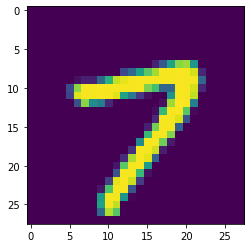

In [336]:
import matplotlib.pyplot as plt
digi = np.random.randint(0,6000)
print(digi)
plt.imshow(x_train[digi])

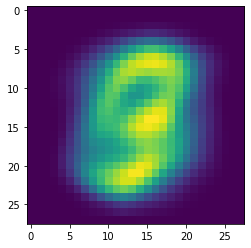

In [339]:
resu = vae(x_train[digi].reshape(1, 784).astype("float32") / 255)
plt.imshow(resu.numpy().reshape((28,28)))

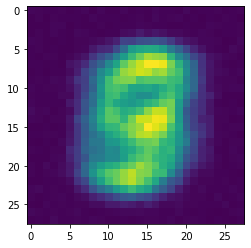

In [329]:
resu = vae(x_train[digi].reshape(1, 784).astype("float32") / 255)
plt.imshow(resu.numpy().reshape((28,28)))

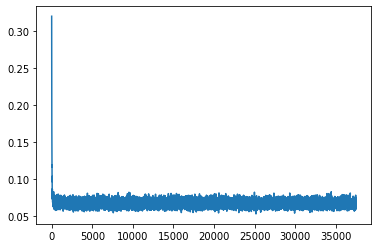

In [340]:
plt.plot(losses)

As you can see, building and training this type of model in Keras
is quick and painless.

Now, you may find that the code above is somewhat verbose: we handle every little detail
on our own, by hand. This gives the most flexibility, but it's also a bit of work.

Let's take a look at what the Functional API version of
our VAE looks like:

In [341]:
original_dim = 784
intermediate_dim = 64
latent_dim = 32

# Define encoder model.
original_inputs = tf.keras.Input(shape=(original_dim,), name="encoder_input")
x = layers.Dense(intermediate_dim, activation="relu")(original_inputs)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()((z_mean, z_log_var))
encoder = tf.keras.Model(inputs=original_inputs, outputs=z, name="encoder")

# Define decoder model.
latent_inputs = tf.keras.Input(shape=(latent_dim,), name="z_sampling")
x = layers.Dense(intermediate_dim, activation="relu")(latent_inputs)
outputs = layers.Dense(original_dim, activation="sigmoid")(x)
decoder = tf.keras.Model(inputs=latent_inputs, outputs=outputs, name="decoder")

# Define VAE model.
outputs = decoder(z)
vae = tf.keras.Model(inputs=original_inputs, outputs=outputs, name="vae")

# Add KL divergence regularization loss.
kl_loss = -0.5 * tf.reduce_mean(z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1)
vae.add_loss(kl_loss)

Much more concise, right?

By the way, Keras also features built-in training & evaluation loops on its `Model` class
(`fit()` and `evaluate()`). Check it out:

In [354]:
# Loss and optimizer.
loss_fn = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

# Prepare a dataset.
(x_ALL, _), _ = tf.keras.datasets.mnist.load_data()
from sklearn.model_selection import train_test_split

x_train, x_val = train_test_split(x_ALL, test_size=0.2, random_state=42)
print(x_train.shape)
dataset = tf.data.Dataset.from_tensor_slices(
    x_train.reshape(x_train.shape[0], 784).astype("float32") / 255
)
print(list(dataset)[0].shape)
dataset = dataset.map(lambda x: (x, x))  # Use x_train as both inputs & targets
dataset = dataset.shuffle(buffer_size=1024).batch(32)

# Configure the model for training.
vae.compile(optimizer, loss=loss_fn)
# Actually training the model.
vae.fit(dataset, epochs=3)

(48000, 28, 28)
(784,)
Epoch 1/3
1500/1500 [==============================] - 3s 2ms/step - loss: 0.0677

In [356]:
# Validation
validation_set =  tf.data.Dataset.from_tensor_slices(
    x_val.reshape(x_val.shape[0], 784).astype("float32") / 255
)
validation_set = validation_set.map(lambda x:(x, x))
validation_set = validation_set.batch(32)
vae.evaluate(validation_set)

375/375 [==============================] - 1s 1ms/step - loss: 0.0672


0.06719693541526794

The use of the Functional API and `fit` reduces our example from 65 lines to 25 lines
(including model definition & training). The Keras philosophy is to offer you
productivity-boosting features like
these, while simultaneously empowering you to write everything yourself to gain absolute
control over every little detail. Like we did in the low-level training loop two
paragraphs earlier.

## End-to-end experiment example 2: hypernetworks.

Let's take a look at another kind of research experiment: hypernetworks.

A hypernetwork is a deep neural network whose weights are generated by another network
(usually smaller).

Let's implement a really trivial hypernetwork: we'll use a small 2-layer network  to
generate the weights of a larger 3-layer network.


In [481]:
import numpy as np

input_dim = 784
classes = 10

# This is the model we'll actually use to predict labels (the hypernetwork).
outer_model = keras.Sequential(
    [
        keras.layers.Dense(64, activation=tf.nn.relu),
        keras.layers.Dense(classes),
    ]
)

# It doesn't need to create its own weights, so let's mark its layers
# as already built. That way, calling `outer_model` won't create new variables.
for layer in outer_model.layers:
    layer.built = True

# This is the number of weight coefficients to generate. Each layer in the
# hypernetwork requires output_dim * input_dim + output_dim coefficients.
num_weights_to_generate = (classes * 64 + classes) + (64 * input_dim + 64)

# This is the model that generates the weights of the `outer_model` above.
inner_model = keras.Sequential(
    [
        keras.layers.Dense(16, activation=tf.nn.relu),
        keras.layers.Dense(num_weights_to_generate, activation=tf.nn.sigmoid),
    ]
)

This is our training loop. For each batch of data:

- We use `inner_model` to generate an array of weight coefficients, `weights_pred`
- We reshape these coefficients into kernel & bias tensors for the `outer_model`
- We run the forward pass of the `outer_model` to compute the actual MNIST predictions
- We run backprop through the weights of the `inner_model` to minimize the
final classification loss

In [484]:
# Loss and optimizer.
batch_size = 1
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
# Prepare a dataset.
(x_train, y_train), _ = tf.keras.datasets.mnist.load_data()
dataset = tf.data.Dataset.from_tensor_slices(
    (x_train.reshape(60000, 784).astype("float32") / 255, y_train)
)

# We'll use a batch size of 1 for this experiment.
dataset = dataset.shuffle(buffer_size=1024).batch(batch_size=batch_size)

@tf.function
def train_step(x, y, accuracy=None):
    with tf.GradientTape() as tape:
        # Predict weights for the outer model.
        weights_pred = inner_model(x)

        # Reshape them to the expected shapes for w and b for the outer model.
        # Layer 0 kernel.
        start_index = 0
        w0_shape = (input_dim, 64)
        w0_coeffs = weights_pred[:, start_index : start_index + np.prod(w0_shape)]
        w0 = tf.reshape(w0_coeffs, w0_shape)
        start_index += np.prod(w0_shape)
        # Layer 0 bias.
        b0_shape = (64,)
        b0_coeffs = weights_pred[:, start_index : start_index + np.prod(b0_shape)]
        b0 = tf.reshape(b0_coeffs, b0_shape)
        start_index += np.prod(b0_shape)
        # Layer 1 kernel.
        w1_shape = (64, classes)
        w1_coeffs = weights_pred[:, start_index : start_index + np.prod(w1_shape)]
        w1 = tf.reshape(w1_coeffs, w1_shape)
        start_index += np.prod(w1_shape)
        # Layer 1 bias.
        b1_shape = (classes,)
        b1_coeffs = weights_pred[:, start_index : start_index + np.prod(b1_shape)]
        b1 = tf.reshape(b1_coeffs, b1_shape)
        start_index += np.prod(b1_shape)

        # Set the weight predictions as the weight variables on the outer model.
        outer_model.layers[0].kernel = w0
        outer_model.layers[0].bias = b0
        outer_model.layers[1].kernel = w1
        outer_model.layers[1].bias = b1

        # Inference on the outer model.
        preds = outer_model(x)
        loss = loss_fn(y, preds)
        #accuracy.update_state(y, preds)

    # Train only inner model.
    grads = tape.gradient(loss, inner_model.trainable_weights)
    optimizer.apply_gradients(zip(grads, inner_model.trainable_weights))
    accuracy.update_state(y, preds)

    return loss

accuracy = tf.keras.metrics.SparseCategoricalCrossentropy(from_logits=True)

epochs = 3
losses = []  # Keep track of the losses over time.
for epoch in range(epochs):
    for step, (x, y) in enumerate(dataset):
        loss = train_step(x, y, accuracy)

        # Logging.
        losses.append(float(loss))
        if step % 10000 == 0:
            print(f"Epoch {epoch}, Step: {step}, Loss: {sum(losses) / len(losses)}"
                  f" accuracy {accuracy.result()}")


        # Stop after 1000 steps.
        # Training the model to convergence is left
        # as an exercise to the reader.
        #if step >= 1000:
        #    break
    accuracy.reset_states()

Epoch 0, Step: 0, Loss: 0.05248716473579407 accuracy 0.05248716473579407
Epoch 0, Step: 10000, Loss: 0.38772799538116415 accuracy 0.3877255320549011
Epoch 0, Step: 20000, Loss: 0.38557633976275035 accuracy 0.38557156920433044
Epoch 0, Step: 30000, Loss: 0.3829237456354154 accuracy 0.3829147517681122
Epoch 0, Step: 40000, Loss: 0.37704242492177403 accuracy 0.3770308196544647
Epoch 0, Step: 50000, Loss: 0.36875272863512654 accuracy 0.3687361478805542
Epoch 1, Step: 0, Loss: 0.3554700606759126 accuracy 0.0483308881521225
Epoch 1, Step: 10000, Loss: 0.3471312685828752 accuracy 0.2970711588859558
Epoch 1, Step: 20000, Loss: 0.33802660385431144 accuracy 0.2856784760951996
Epoch 1, Step: 30000, Loss: 0.32950839526000497 accuracy 0.2775696814060211
Epoch 1, Step: 40000, Loss: 0.31987382788539853 accuracy 0.2664610743522644
Epoch 1, Step: 50000, Loss: 0.31268991185998785 accuracy 0.26133468747138977
Epoch 2, Step: 0, Loss: 0.3016983097637457 accuracy 1.9788545614574105e-05
Epoch 2, Step: 10000,

Implementing arbitrary research ideas with Keras is straightforward and highly
productive. Imagine trying out 25 ideas per day (20 minutes per experiment on average)!

Keras has been designed to go from idea to results as fast as possible, because we
believe this is
the key to doing great research.

We hope you enjoyed this quick introduction. Let us know what you build with Keras!

## Comparision to MLP classification

In [496]:
classes = 10
input_dim = 784 # 28 * 28
batch_size = 30
epochs = 3

(x_train, y_train), (x_val, y_val) = tf.keras.datasets.mnist.load_data()
x_train = x_train.reshape(x_train.shape[0], np.prod(x_train.shape[1:])).astype("float32") / 255

original_inputs = tf.keras.Input(shape=( input_dim), name="img_input")
x = keras.layers.Dense(64, activation=tf.nn.relu, name= "hid1")(original_inputs)
outputs = keras.layers.Dense(classes, activation = tf.nn.softmax, name= "out")(x)

model = tf.keras.Model(inputs=original_inputs, outputs=outputs, name="simple_model")
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics='accuracy')
model.summary()
model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs)

Model: "simple_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img_input (InputLayer)       [(None, 784)]             0         
_________________________________________________________________
hid1 (Dense)                 (None, 64)                50240     
_________________________________________________________________
out (Dense)                  (None, 10)                650       
Total params: 50,890
Trainable params: 50,890
Non-trainable params: 0
_________________________________________________________________
Epoch 1/3
2000/2000 [==============================] - 2s 923us/step - loss: 1.9470 - accuracy: 0.6192

### Testing wih one hot encoding of y
Note : loss as to change to tf.keras.losses.CategoricalCrossentropy(from_logits=False)
(not SparseCategoricalCr.. and not from logits)

In [494]:
from tensorflow.keras.utils import to_categorical

(x_train, y_train), (x_val, y_val) = tf.keras.datasets.mnist.load_data()
x_train = x_train.reshape(x_train.shape[0], np.prod(x_train.shape[1:])).astype("float32") / 255

encoded = to_categorical(y_train)
print(encoded.shape)

original_inputs = tf.keras.Input(shape=(input_dim), name="img_input")
x = keras.layers.Dense(64, activation=tf.nn.relu, name= "hid1")(original_inputs)
outputs = keras.layers.Dense(classes, activation = tf.nn.softmax, name= "out")(x)

model = tf.keras.Model(inputs=original_inputs, outputs=outputs, name="simple_model")
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics='accuracy')

model.summary()

model.fit(x_train, encoded, batch_size=batch_size, epochs=epochs)#, validation_data=validation_set)

(60000, 10)
Model: "simple_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img_input (InputLayer)       [(None, 784)]             0         
_________________________________________________________________
hid1 (Dense)                 (None, 64)                50240     
_________________________________________________________________
out (Dense)                  (None, 10)                650       
Total params: 50,890
Trainable params: 50,890
Non-trainable params: 0
_________________________________________________________________
Epoch 1/3
2000/2000 [==============================] - 2s 997us/step - loss: 1.1573 - accuracy: 0.6722

### With keras.Sequential

In [504]:
from tensorflow.keras.utils import to_categorical

model = tf.keras.Sequential([
    tf.keras.Input(shape=(input_dim), name='flat_img_input'),
    tf.keras.layers.Dense(64, name='hid1', activation=tf.nn.relu),
    tf.keras.layers.Dense(classes, name='output', activation=tf.nn.softmax)
])

(x_train, y_train), (x_val, y_val) = tf.keras.datasets.mnist.load_data()
x_train = x_train.reshape(x_train.shape[0], np.prod(x_train.shape[1:])).astype("float32") / 255

encoded = to_categorical(y_train)
print(encoded.shape)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics='accuracy')
model.summary()
model.fit(x_train, encoded, batch_size=batch_size, epochs=epochs)

(60000, 10)
Model: "sequential_92"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hid1 (Dense)                 (None, 64)                50240     
_________________________________________________________________
output (Dense)               (None, 10)                650       
Total params: 50,890
Trainable params: 50,890
Non-trainable params: 0
_________________________________________________________________
Epoch 1/3
2000/2000 [==============================] - 2s 1ms/step - loss: 1.1527 - accuracy: 0.6835

### Adding Dropout

In [505]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dropout
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(input_dim), name='flat_img_input'),
    tf.keras.layers.Dense(64, name='hid1', activation=tf.nn.relu),
    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Dense(classes, name='output', activation=tf.nn.softmax)
], name="sparse_mlp_dropout")

(x_train, y_train), (x_val, y_val) = tf.keras.datasets.mnist.load_data()
x_train = x_train.reshape(x_train.shape[0], np.prod(x_train.shape[1:])).astype("float32") / 255
# #x_val = x_val.reshape(x_val.shape[0], np.prod(x_val.shape[1:])).astype("float32") / 255
# validation_set = tf.data.Dataset.from_tensor_slices(
#      (x_val.reshape(x_val.shape[0], np.prod(x_val.shape[1:])).astype("float32") / 255, y_val)
# )

encoded = to_categorical(y_train)
print(encoded.shape)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics='accuracy')
model.summary()
#, validation_data=validation_set
model.fit(x_train, encoded, batch_size=batch_size, epochs=epochs)



(60000, 10)
Model: "sparse_mlp_dropout"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hid1 (Dense)                 (None, 64)                50240     
_________________________________________________________________
dropout_39 (Dropout)         (None, 64)                0         
_________________________________________________________________
output (Dense)               (None, 10)                650       
Total params: 50,890
Trainable params: 50,890
Non-trainable params: 0
_________________________________________________________________
Epoch 1/3
2000/2000 [==============================] - 2s 988us/step - loss: 1.4713 - accuracy: 0.5264

Model: "sparse_mlp_dropout"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hid1 (Dense)                 (None, 64)                50240     
_________________________________________________________________
dropout_29 (Dropout)         (None, 64)                0         
_________________________________________________________________
output (Dense)               (None, 10)                650       
Total params: 50,890
Trainable params: 50,890
Non-trainable params: 0
_________________________________________________________________


### training with train and validation set (using tf.data.Dataset.from_tensor_slices)

In [522]:
#from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dropout
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(input_dim), name='flat_img_input'),
    tf.keras.layers.Dense(64, name='hid1', activation=tf.nn.relu),
    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Dense(classes, name='output', activation=tf.nn.softmax)
], name="sparse_mlp_dropout_validation")

(x_train, y_train), (x_val, y_val) = tf.keras.datasets.mnist.load_data()

training_set = tf.data.Dataset.from_tensor_slices(
     (x_train.reshape(x_train.shape[0], np.prod(x_train.shape[1:])).astype("float32") / 255, y_train)
)
training_set = training_set.shuffle(buffer_size=1024).batch(batch_size=batch_size)

validation_set = tf.data.Dataset.from_tensor_slices(
     (x_val.reshape(x_val.shape[0], np.prod(x_val.shape[1:])).astype("float32") / 255, y_val)
)
## validation set has to be split in batches
validation_set = validation_set.shuffle(buffer_size=1024).batch(batch_size=batch_size)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics='accuracy')
model.summary()
#
model.fit(training_set, batch_size=batch_size,
          epochs=epochs, validation_data=validation_set)

Model: "sparse_mlp_dropout_validation"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hid1 (Dense)                 (None, 64)                50240     
_________________________________________________________________
dropout_53 (Dropout)         (None, 64)                0         
_________________________________________________________________
output (Dense)               (None, 10)                650       
Total params: 50,890
Trainable params: 50,890
Non-trainable params: 0
_________________________________________________________________
Epoch 1/3
2000/2000 [==============================] - 3s 2ms/step - loss: 2.0446 - accuracy: 0.4989 - val_loss: 1.6422 - val_accuracy: 0.8796

In [515]:
val_flattened = x_val.reshape(x_val.shape[0], np.prod(x_val.shape[1:])).astype("float32") / 255
model.predict(val_flattened[0:4])

array([[3.11849874e-07, 1.39464111e-08, 1.92713946e-06, 3.33720054e-05,
        9.55639905e-08, 6.37382868e-07, 4.96210351e-10, 9.99799311e-01,
        3.20410948e-07, 1.64018100e-04],
       [1.99362039e-05, 1.71110241e-06, 9.99438465e-01, 3.99847195e-04,
        3.45358386e-09, 3.63073377e-05, 8.37532862e-05, 1.08996410e-07,
        1.96523324e-05, 1.08666775e-07],
       [1.70681051e-05, 9.92434740e-01, 1.78573420e-03, 6.53882860e-04,
        5.84141817e-04, 3.18076171e-04, 8.59691470e-04, 1.65416091e-03,
        1.30085018e-03, 3.91614944e-04],
       [9.99941468e-01, 9.37502576e-11, 8.02428588e-07, 3.14361000e-06,
        2.04416306e-09, 1.77250949e-05, 3.87078353e-06, 3.04595178e-05,
        2.23004440e-06, 2.74533704e-07]], dtype=float32)

### training with validation data (not using .Dataset.from_tensor_slices)

In [516]:
#from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dropout
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(input_dim), name='flat_img_input'),
    tf.keras.layers.Dense(64, name='hid1', activation=tf.nn.relu),
    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Dense(classes, name='output', activation=tf.nn.softmax)
], name="sparse_mlp_dropout_validation")

(x_train, y_train), (x_val, y_val) = tf.keras.datasets.mnist.load_data()
x_train = x_train.reshape(x_train.shape[0], np.prod(x_train.shape[1:])).astype("float32") / 255
x_val = x_val.reshape(x_val.shape[0], np.prod(x_val.shape[1:])).astype("float32") / 255
## validation set has to be split in batches
validation_set = validation_set.shuffle(buffer_size=1024).batch(batch_size=batch_size)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics='accuracy')
model.summary()
#
model.fit(x_train, y_train, batch_size=batch_size,
          epochs=epochs, validation_data=(x_val, y_val))

Model: "sparse_mlp_dropout_validation"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hid1 (Dense)                 (None, 64)                50240     
_________________________________________________________________
dropout_47 (Dropout)         (None, 64)                0         
_________________________________________________________________
output (Dense)               (None, 10)                650       
Total params: 50,890
Trainable params: 50,890
Non-trainable params: 0
_________________________________________________________________
Epoch 1/3
2000/2000 [==============================] - 3s 1ms/step - loss: 2.0431 - accuracy: 0.4994 - val_loss: 1.6453 - val_accuracy: 0.8711